 
# Minimizing memory usage: a matrix-free iterative solver
## How to deal with dense BEM matrices?

[In the previous section, I explained how to directly discretize a free surface using TDEs](sa_tdes). A downside of this approach is that the surface matrix can get very large very quickly. If I make the width of an element half as large, then there will be 2x many elements per dimension and 4x as many elements overall. And because the interaction matrix is dense, 4x as many elements leads to 16x as many matrix entries. In other words, $n$, the number of elements, scales like $O(h^2)$ in terms of the element width $h$. And the number of matrix rows or columns is exactly $3n$ (the 3 comes from the vector nature of the problem). That requires storing $9n^2$ entries. And, even worse, using a direct solver (LU decomposition, Gaussian elimination, etc) with such a matrix requires time like $O(n^3)$. Even for quite small problems with 10,000 elements, the cost of storage and solution get very large. And without an absolutely enormous machine or a distributed parallel implementation, solving a problem with 200,000 elements will just not be possible. On the other hand, in an ideal world, it would be nice to be able to solve problems with millions or even tens or hundreds of millions of elements. 

Fundamentally, the problem is that the interaction matrix is dense. There are two approaches for resolving this problem:
1. Don't store the matrix!
2. Compress the matrix by taking advantage of low rank sub-blocks.

Eventually approach #2 will be critical since it is scalable up to very large problems. And that's exactly what I'll do in the next sections where I'll investigate low-rank methods and hierarchical matrices (H-matrices). However, here, I'll demonstrate approach #1 by using a matrix-free iterative solver. Ultimately, this is just a small patch on a big problem and it won't be a sustainable solution. But, it's immediately useful when you don't have a working implementation, are running into RAM constraints and are okay with a fairly slow solution. It's also useful to introduce iterative linear solvers since they are central to solving BEM linear systems.

When we solve a linear system without storing the matrix, [the method is called "matrix-free"](https://en.wikipedia.org/wiki/Matrix-free_methods). Generally, we'll just recompute any matrix entry whenever we need. How does this do algorithmically? The storage requirements drop to just the $O(n)$ source and observation info instead of the $O(n^2)$ dense matrix. And, as I'll demonstrate, for some problems, the runtime will drop to $O(n^2)$ instead of $O(n^3)$ because solving linear systems will be possible with a fixed and fairly small number of matrix-vector products.


## A demonstration on a large mesh.

To get started, I'll just copy the code to set up the linear system for the South America problem from the previous section. But, as a twist, I'll going to use a mesh with several times more elements. This surface mesh has 28,388 elements. As a result, the matrix would have 3x that many rows and columns and would require 58 GB of memory to store. That's still small enough that it could be stored on a medium sized workstation. But, it's too big for my personal computer!

In [1]:
import cutde
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer

plt.rcParams["text.usetex"] = True
%config InlineBackend.figure_format='retina'
(surf_pts_lonlat, surf_tris), (fault_pts_lonlat, fault_tris) = np.load(
    "sa_mesh16_7216.npy", allow_pickle=True
)

In [2]:
print("Memory required to store this matrix: ", (surf_tris.shape[0] * 3) ** 2 * 8 / 1e9)

Memory required to store this matrix:  58.023255168


In [3]:
transformer = Transformer.from_crs(
    "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
    "+proj=geocent +datum=WGS84 +units=m +no_defs",
)
surf_pts_xyz = np.array(
    transformer.transform(
        surf_pts_lonlat[:, 0], surf_pts_lonlat[:, 1], surf_pts_lonlat[:, 2]
    )
).T.copy()
fault_pts_xyz = np.array(
    transformer.transform(
        fault_pts_lonlat[:, 0], fault_pts_lonlat[:, 1], fault_pts_lonlat[:, 2]
    )
).T.copy()

surf_tri_pts_xyz = surf_pts_xyz[surf_tris]
surf_xyz_to_tdcs_R = cutde.compute_efcs_to_tdcs_rotations(surf_tri_pts_xyz)

fault_centers_lonlat = np.mean(fault_pts_lonlat[fault_tris], axis=1)
fault_lonlat_to_xyz_T = cutde.compute_projection_transforms(
    fault_centers_lonlat, transformer
)

fault_tri_pts_xyz = fault_pts_xyz[fault_tris]
fault_xyz_to_tdcs_R = cutde.compute_efcs_to_tdcs_rotations(fault_tri_pts_xyz)

fault_tri_pts_lonlat = fault_pts_lonlat[fault_tris]
fault_tdcs2_to_lonlat_R = cutde.compute_efcs_to_tdcs_rotations(fault_tri_pts_lonlat)

strike_lonlat = fault_tdcs2_to_lonlat_R[:, 0, :]
dip_lonlat = fault_tdcs2_to_lonlat_R[:, 1, :]

strike_xyz = np.sum(fault_lonlat_to_xyz_T * strike_lonlat[:, None, :], axis=2)
strike_xyz /= np.linalg.norm(strike_xyz, axis=1)[:, None]
dip_xyz = np.sum(fault_lonlat_to_xyz_T * dip_lonlat[:, None, :], axis=2)
dip_xyz /= np.linalg.norm(dip_xyz, axis=1)[:, None]

ft = np.float32
# The normal vectors for each triangle are the third rows of the XYZ->TDCS rotation matrices.
Vnormal = surf_xyz_to_tdcs_R[:, 2, :]
surf_centers_xyz = np.mean(surf_tri_pts_xyz, axis=1)
surf_tri_pts_xyz_conv = surf_tri_pts_xyz.astype(ft)

# The rotation matrix from TDCS to XYZ is the transpose of XYZ to TDCS.
# The inverse of a rotation matrix is its transpose.
surf_tdcs_to_xyz_R = np.transpose(surf_xyz_to_tdcs_R, (0, 2, 1)).astype(ft)

Proceeding like the previous section, the next step would be to construct our surface to surface left hand side matrix. But, instead, I'm just going to compute the action of that matrix without ever storing the entire matrix. Essentially, each matrix entry will be recomputed whenever it is needed. The `cutde.disp_free` and `cutde.strain_free` were written for this purpose. 

First, let's check that the `cutde.disp_free` matrix free TDE computation is doing what I said it does. That is, it should be computing a matrix vector product. Since our problem is too big to generate the full matrix in memory, I'll just use the first 100 elements for this test.

First, I'll compute the matrix form. This should look familiar! I multiply the matrix by a random slip vector.

In [4]:
test_centers = (surf_centers_xyz - 1.0 * Vnormal)[:100].astype(ft)
mat = cutde.disp_matrix(test_centers, surf_tri_pts_xyz_conv[:100], 0.25).reshape(
    (300, 300)
)
slip = np.random.rand(mat.shape[1]).astype(ft)
correct_disp = mat.dot(slip)

And now the matrix free version. Note that the slip is passed to the `disp_free` function. This makes sense since it is required for a matrix-vector product even though it is not required to construct the matrix with `cutde.disp_matrix`.

In [5]:
test_disp = cutde.disp_free(
    test_centers, surf_tri_pts_xyz_conv[:100], slip.reshape((-1, 3)), 0.25
)

And let's calculate the error... It looks good for the first element. For 32-bit floats, this is machine precision.

In [6]:
err = correct_disp.reshape((-1, 3)) - test_disp
err[0]

array([ 4.4703484e-08, -1.7881393e-07, -5.4389238e-07], dtype=float32)

In [7]:
np.mean(np.abs(err)), np.max(np.abs(err))

(2.9506162e-07, 1.2218952e-06)

Okay, now that I've shown that `cutde.disp_free` is trustworthy, let's construct the full action of the left-hand side matrix. We need to transform all the rotation and extrapolation steps into a form that makes sense in an "on the fly" setting where we're not storing a matrix.

In [8]:
offsets = [2.0, 1.0]
offset_centers = [(surf_centers_xyz - off * Vnormal).astype(ft) for off in offsets]
surf_xyz_to_tdcs_R = surf_xyz_to_tdcs_R.astype(ft)

# The extrapolate to the boundary step looked like:
# lhs = 2 * eps_mats[1] - eps_mats[0]
# This array stores the coefficients so that we can apply that formula
# on the fly.
extrapolation_mult = [-1, 2]


def matvec(x):
    # Step 1) Rotate slip into the TDE-centric coordinate system.
    slip_xyz = x.reshape((-1, 3)).astype(ft)
    slip_tdcs = np.ascontiguousarray(
        np.sum(surf_xyz_to_tdcs_R * slip_xyz[:, None, :], axis=2)
    )
    # Step 2) Compute the two point extrapolation to the boundary.
    out = np.zeros_like(offset_centers[0])
    for i, off in enumerate(offsets):
        out += extrapolation_mult[i] * cutde.disp_free(
            offset_centers[i], surf_tri_pts_xyz_conv, slip_tdcs, 0.25
        )
    out = out.flatten()

    # Step 3) Don't forget the diagonal Identity matrix term!
    out += x
    return out

In [9]:
%%time
matvec(np.random.rand(surf_tris.shape[0] * 3))

CPU times: user 8.16 s, sys: 0 ns, total: 8.16 s
Wall time: 8.16 s


array([-0.07595471,  0.14888829,  0.00571918, ...,  0.11337244,  0.06799013,  0.37440816], dtype=float32)

Great! We computed a matrix-free matrix-vector product! This little snippet below will demonstrate that the memory usage is still well under 1 GB proving that we're not storing a matrix anywhere.

In [10]:
import os, psutil

process = psutil.Process(os.getpid())
print(process.memory_info().rss / 1e9)

0.178192384


## Iterative linear solution

Okay, so how do we use this matrix-vector product to solve the linear system? Because the entire matrix is never in memory, direct solvers like LU decomposition or Cholesky decomposition are no longer an option. But, iterative linear solvers are still an option. The [conjugate gradient (CG) method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) is a well-known example of an iterative solver. However, CG requires a symmetric positive definite matrix. Because our columns come from integrals over elements but our rows come from observation points, there is an inherent asymmetry to the boundary element matrices we are producing here. [GMRES](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method) is an iterative linear solver that tolerates asymmetry. It's specifically a type of ["Krylov subspace"](https://en.wikipedia.org/wiki/Krylov_subspace) iterative linear solver and as such requires only the set of vectors:
\begin{equation}
\{b, Ab, A^2b, ..., A^nb\}
\end{equation}
As such, only having an implementation of the matrix vector product $Ab$ is required since the later iterates can be computed with multiple matrix vector product. For example, $A^2b = A(Ab)$.

To start, we compute the right-hand side which is nothing new or fancy.

In [11]:
slip = np.sum(fault_xyz_to_tdcs_R * dip_xyz[:, None, :], axis=2)
rhs = cutde.disp_free(
    surf_centers_xyz.astype(ft), fault_pts_xyz[fault_tris].astype(ft), slip, 0.25
).flatten()

/home/tbent/Dropbox/active/eq/cutde/cutde/fullspace.py:69: UserWarning: The slips input array has type float64 but needs to be converted to dtype float32. Converting slips to float32 may be expensive.
  warnings.warn(
/home/tbent/Dropbox/active/eq/cutde/cutde/fullspace.py:78: UserWarning: The slips input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(


Now, the fun stuff: Here, I'll use the [`scipy` implementation of GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html). First, we need to do use the `scipy.sparse.linalg.LinearOperator` interface to wrap our `matvec` function in a form that the `gmres` function will recognize as a something that represents a linear system that can be solved.

In [12]:
import time
import scipy.sparse.linalg as spla

# The number of rows and columns
n = surf_tris.shape[0] * 3

# The matrix vector product function that serves as the "backend" for the LinearOperator.
# This is just a handy wrapper around matvec to track the number of matrix-vector products
# used during the linear solve process.
def M(x):
    M.n_iter += 1
    start = time.time()
    out = matvec(x)
    print("n_matvec", M.n_iter, "took", time.time() - start)
    return out


M.n_iter = 0
lhs = spla.LinearOperator((n, n), M, dtype=rhs.dtype)
lhs.shape

(85164, 85164)

And then we can pass that `LinearOperator` as the left hand side of a system of equations to `gmres`. I'm also going to pass a simple callback that will print the current residual norm at each step of the iterative solver and require a solution tolerance of `1e-4`.

In [13]:
np.linalg.norm(rhs)

26.985018

In [14]:
soln = spla.gmres(
    lhs,
    rhs,
    tol=1e-4,
    atol=1e-4,
    restart=100,
    maxiter=1,
    callback_type="pr_norm",
    callback=lambda x: print(x),
)
soln = soln[0].reshape((-1, 3))

n_matvec 1 took 8.181740522384644
n_matvec 2 took 8.217356204986572
0.21284150158882
n_matvec 3 took 8.110730171203613
0.026337904611568017
n_matvec 4 took 8.143013715744019
0.0058701005433943266
n_matvec 5 took 8.101205348968506
0.0016042871687649372
n_matvec 6 took 8.221377849578857
0.0004220627227557851
n_matvec 7 took 8.234569311141968
9.5677343550821e-05


As the figures below demonstrate, only eight matrix-vector products got us a great solution!

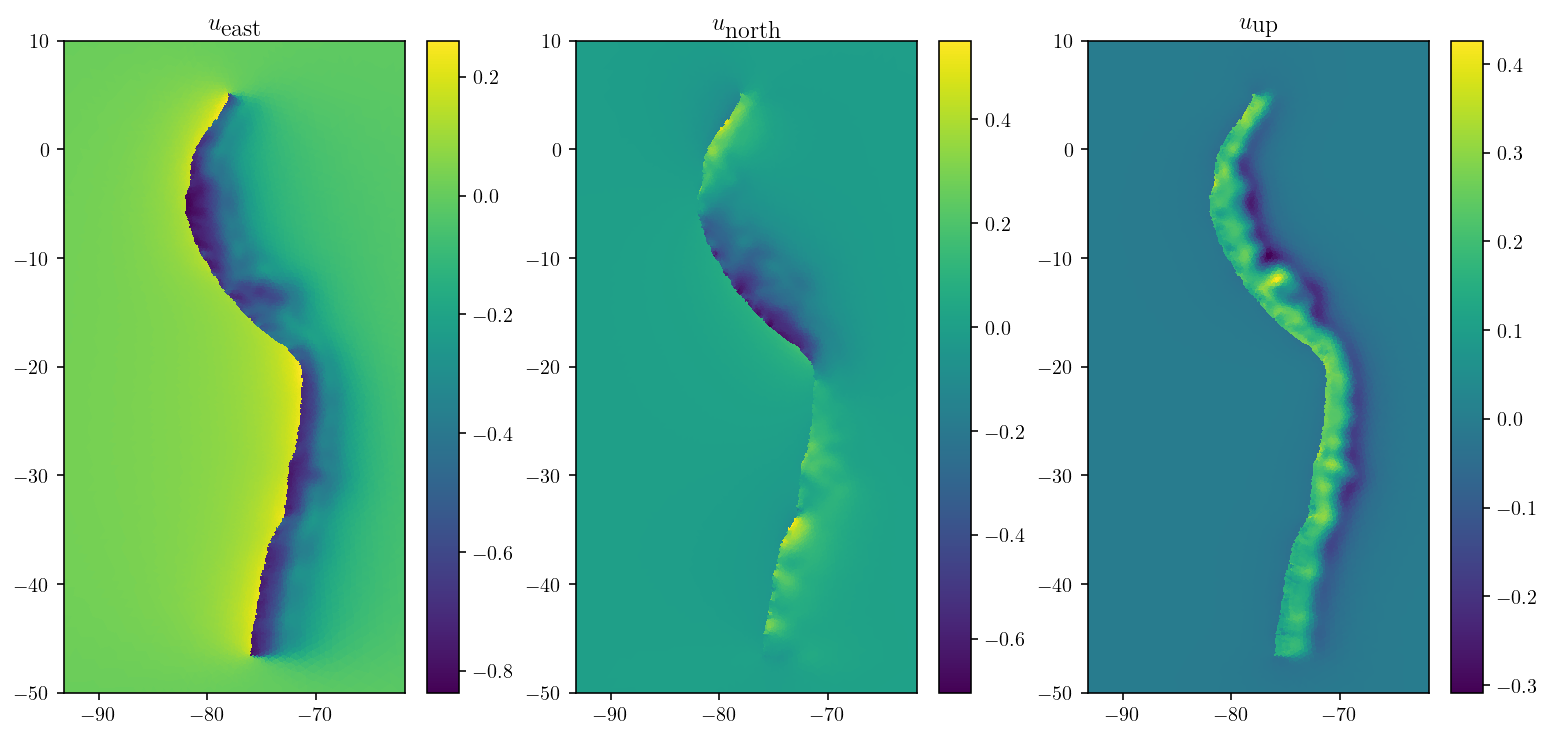

In [15]:
inverse_transformer = Transformer.from_crs(
    "+proj=geocent +datum=WGS84 +units=m +no_defs",
    "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
)
surf_xyz_to_lonlat_T = cutde.compute_projection_transforms(
    surf_centers_xyz, inverse_transformer
)
surf_xyz_to_lonlat_T /= np.linalg.norm(surf_xyz_to_lonlat_T, axis=2)[:, :, None]
soln_lonlat = np.sum(surf_xyz_to_lonlat_T * soln[:, None, :], axis=2)

plt.figure(figsize=(13, 6))
for d in range(3):
    plt.subplot(1, 3, 1 + d)
    cntf = plt.tripcolor(
        surf_pts_lonlat[:, 0], surf_pts_lonlat[:, 1], surf_tris, soln_lonlat[:, d]
    )
    plt.colorbar(cntf)
    plt.axis("equal")
    plt.xlim([-85, -70])
    plt.ylim([-50, 10])
    plt.title(
        ["$u_{\\textrm{east}}$", "$u_{\\textrm{north}}$", "$u_{\\textrm{up}}$"][d]
    )
plt.show()

## Performance and convergence

An important thing to note about the solution above is that only a few matrix-vector products are required to get to a high-level of accuracy. GMRES (and many other iterative linear and nonlinear optimization algorithms) converges at a rate proportional to the condition number of the matrix {cite:p}`Saad1986`. So in order to productively use an iterative linear solver, we need to have a matrix with a small condition number. It turns out that these free surface self-interaction matrices have condition numbers that are very close to 1.0, meaning that all the eigenvalues are very similar in magnitude. As a result, a highly accurate solution with GMRES requires less than ten matrix-vector products even for very large matrices. 

Because of this dependence on the condition number, in the worst case, iterative solvers are not faster than a direct solver. However, suppose that we need only 10 matrix-vector products. Then, the runtime is approximately $10(2n^2)$ because each matrix-vector product requires $2n^2$ operations (one multiplication and one addition per matrix entry). As a result, GMRES is solving the problem in $O(n^2)$ instead of the $O(n^3)$ asymptotic runtime of direct methods like LU decomposition. So, in addition to requiring less memory, the matrix free method here forced us into actually using a faster linear solver. Of course, LU decomposition comes out ahead again if we need to solve many linear systems with the same left hand side and different right hand sides. That is not the case here but would be relevant for many other problems (e.g. problems involving time stepping).

The mess of code below builds a few figures that demonstrate these points regarding performance and accuracy as a function of the number of elements.

In [16]:
import time

fault_L = 1000.0
fault_H = 1000.0
fault_D = 0.0
fault_pts = np.array(
    [
        [-fault_L, 0, -fault_D],
        [fault_L, 0, -fault_D],
        [fault_L, 0, -fault_D - fault_H],
        [-fault_L, 0, -fault_D - fault_H],
    ]
)
fault_tris = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)

results = []
for n_els_per_dim in [2, 4, 8, 16, 32, 48]:
    surf_L = 4000
    mesh_xs = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
    mesh_ys = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
    mesh_xg, mesh_yg = np.meshgrid(mesh_xs, mesh_ys)
    surf_pts = np.array([mesh_xg, mesh_yg, 0 * mesh_yg]).reshape((3, -1)).T.copy()
    surf_tris = []
    nx = ny = n_els_per_dim + 1
    idx = lambda i, j: i * ny + j
    for i in range(n_els_per_dim):
        for j in range(n_els_per_dim):
            x1, x2 = mesh_xs[i : i + 2]
            y1, y2 = mesh_ys[j : j + 2]
            surf_tris.append([idx(i, j), idx(i + 1, j), idx(i + 1, j + 1)])
            surf_tris.append([idx(i, j), idx(i + 1, j + 1), idx(i, j + 1)])
    surf_tris = np.array(surf_tris, dtype=np.int64)
    surf_tri_pts = surf_pts[surf_tris]
    surf_centroids = np.mean(surf_tri_pts, axis=1)

    fault_surf_mat = cutde.disp_matrix(surf_centroids, fault_pts[fault_tris], 0.25)
    rhs = np.sum(fault_surf_mat[:, :, :, 0], axis=2).flatten()

    start = time.time()
    eps_mats = []
    offsets = [0.002, 0.001]
    offset_centers = [
        np.mean(surf_tri_pts, axis=1) - off * np.array([0, 0, 1]) for off in offsets
    ]
    for i, off in enumerate(offsets):
        eps_mats.append(cutde.disp_matrix(offset_centers[i], surf_pts[surf_tris], 0.25))
    lhs = 2 * eps_mats[1] - eps_mats[0]
    lhs_reordered = np.empty_like(lhs)
    lhs_reordered[:, :, :, 0] = lhs[:, :, :, 1]
    lhs_reordered[:, :, :, 1] = lhs[:, :, :, 0]
    lhs_reordered[:, :, :, 2] = lhs[:, :, :, 2]
    lhs_reordered = lhs_reordered.reshape(
        (surf_tris.shape[0] * 3, surf_tris.shape[0] * 3)
    )
    lhs_reordered += np.eye(lhs_reordered.shape[0])
    direct_build_time = time.time() - start
    start = time.time()
    soln = np.linalg.solve(lhs_reordered, rhs).reshape((-1, 3))
    direct_solve_time = time.time() - start

    def matvec(x):
        extrapolation_mult = [-1, 2]
        slip = np.empty((surf_centroids.shape[0], 3))
        xrshp = x.reshape((-1, 3))
        slip[:, 0] = xrshp[:, 1]
        slip[:, 1] = xrshp[:, 0]
        slip[:, 2] = xrshp[:, 2]
        out = np.zeros_like(offset_centers[0])
        for i, off in enumerate(offsets):
            out += extrapolation_mult[i] * cutde.disp_free(
                offset_centers[i], surf_tri_pts, slip, 0.25
            )
        return out.flatten() + x

    n = surf_tris.shape[0] * 3

    def M(x):
        M.n_iter += 1
        return matvec(x)

    M.n_iter = 0
    lhs = spla.LinearOperator((n, n), M, dtype=rhs.dtype)
    start = time.time()
    soln_iter = spla.gmres(lhs, rhs, tol=1e-4)[0].reshape((-1, 3))
    iterative_runtime = time.time() - start

    l1_err = np.mean(np.abs((soln_iter - soln) / soln))
    results.append(
        dict(
            l1_err=l1_err,
            n_elements=surf_tris.shape[0],
            iterations=M.n_iter,
            direct_build_time=direct_build_time,
            direct_solve_time=direct_solve_time,
            iterative_runtime=iterative_runtime,
            direct_memory=rhs.nbytes + lhs_reordered.nbytes,
            iterative_memory=rhs.nbytes,
        )
    )

In [17]:
import pandas as pd

results_df = pd.DataFrame({k: [r[k] for r in results] for k in results[0].keys()})
results_df["direct_runtime"] = (
    results_df["direct_build_time"] + results_df["direct_solve_time"]
)
results_df

,l1_err,n_elements,iterations,direct_build_time,direct_solve_time,iterative_runtime,direct_memory,iterative_memory,direct_runtime
0,0.000390,8,6,0.001730,0.000297,0.196446,4800,192,0.002027
1,0.000052,32,7,0.001941,0.000353,0.045686,74496,768,0.002294
2,0.000371,128,7,0.007796,0.001663,0.152800,1182720,3072,0.009458
3,0.000520,512,7,0.085798,0.037337,0.748936,18886656,12288,0.123135
4,0.000599,2048,7,1.271554,1.452238,2.974715,302039040,49152,2.723793
5,0.000887,4608,7,6.120567,13.449475,11.854967,1528934400,110592,19.570042


In [18]:
plt.rcParams["text.usetex"] = False

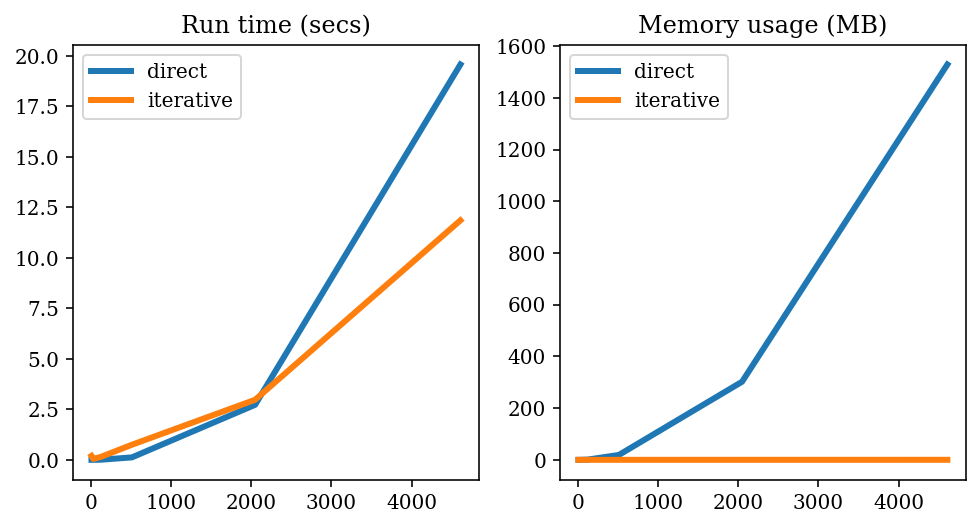

In [19]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(results_df["n_elements"], results_df["direct_runtime"], label="direct")
plt.plot(results_df["n_elements"], results_df["iterative_runtime"], label="iterative")
plt.legend()
plt.title("Run time (secs)")
plt.subplot(1, 2, 2)
plt.plot(results_df["n_elements"], results_df["direct_memory"] / 1e6, label="direct")
plt.plot(
    results_df["n_elements"], results_df["iterative_memory"] / 1e6, label="iterative"
)
plt.legend()
plt.title("Memory usage (MB)")
plt.show()